---
layout: post
title: Blog Post 4
---

In this blog post, we'll learn what *spectral clustering* algorithm for clustering data points is and how it works. 

# Setup

In the very beginning, import the libraries we need to use.

In [4]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
import scipy

# Introduction

**Spectral clustering** is an important tool for identifying meaningful parts of data sets with complex structure.

Also, K-means is a very common way for clustering. But, what is the difference between these two and which one is better in some situations?

Let me take an example of K-means at first

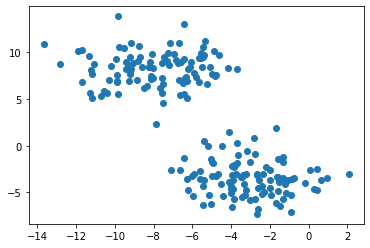

In [5]:
n = 200
np.random.seed(1111)
X, y = datasets.make_blobs(n_samples=n, shuffle=True, random_state=None, centers = 2, cluster_std = 2.0)
plt.scatter(X[:,0], X[:,1])

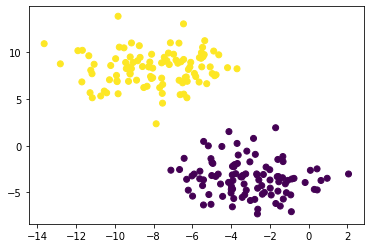

In [6]:
km = KMeans(n_clusters = 2)
km.fit(X)

plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Apparently, K-means did a really good job on circular-ish blobs like these.

Okay. Let's do some harder clustering. Make our data be like "shaped weird".

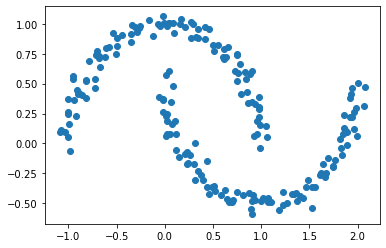

In [7]:
np.random.seed(1234)
n = 200
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)
plt.scatter(X[:,0], X[:,1])

Here, the matrix `X` contains the *Euclidean* coordinates of the data points, and `y` contains the labels of each point.

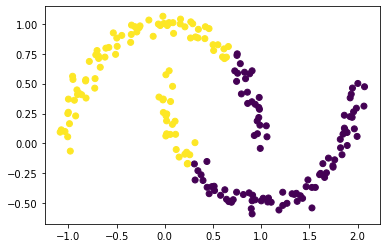

In [8]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Ohhh, we can clearly see that K-means doesn't work so well. Actually it does make sense because K-means is designed for looking for circular clusters.

Now, it is time to back to our topic, spectral clustering. Spectral clustering can have a better performance on clustering the two crescents than K-means. In the next few parts, we will know how spectral clustering works.

# Part A

First, we need to construct the *similarity matrix* $\mathbf{A}$. Since `n` is the number of data points, $\mathbf{A}$ should be a 2d matrix with shape `(n, n)`. 

We should get our `distance_matrix` and use parameter `epsilon` to contruct $\mathbf{A}$. 

`A[i,j]` is 1 if `X[i]` <= `epsilon` of `X[j]`, and `0` otherwise. 

Here we let `epsilon` = 0.4.

In [9]:
# get the distance_matrix
distance_matrix = pairwise_distances(X)
print(distance_matrix)

# contruct the similarity matrix 𝐀
epsilon = 0.4
A = distance_matrix

# transfer the martix's entries based on epsilon
distance_matrix = pairwise_distances(X) 
A = np.zeros_like(distance_matrix)
A[distance_matrix <= epsilon] = 1
np.fill_diagonal(A,0)

#  set the values of the diagonal of 𝐀.
np.fill_diagonal(A,0)
A

[[0.         1.27292462 1.33315598 ... 1.9812102  1.68337039 1.94073324]
 [1.27292462 0.         1.46325112 ... 1.93729167 1.68543003 1.91287315]
 [1.33315598 1.46325112 0.         ... 0.64857172 0.35035968 0.60860868]
 ...
 [1.9812102  1.93729167 0.64857172 ... 0.         0.30070415 0.04219636]
 [1.68337039 1.68543003 0.35035968 ... 0.30070415 0.         0.26255757]
 [1.94073324 1.91287315 0.60860868 ... 0.04219636 0.26255757 0.        ]]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

{::options parse_block_html="true" /}
<div class="got-help">
    
For this part, I used to write one part like these:
    
```python
mask_1 = A <= epsilon
mask_2 = A > epsilon
A[mask_1] = 1
A[mask_2] = 0
```

The output is correct. But when I write my `similarity(X,epsilon)` function on Part G, there is a "singular matrix" error message that I cannot use my final function to cluster the data set. Therefore, I did some changes to this and it works well.
    
</div>
{::options parse_block_html="false" /}

# Part B

Cluster the data points in `X` as partitioning the rows and columns of similarity matrix `A`. 

Let's compute *binary norm cut objective* of a matrix $\mathbf{A}$:

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

In this expression, 
- $\mathbf{cut}(C_0, C_1) \equiv \sum_{i \in C_0, j \in C_1} a_{ij}$ is the *cut* of the clusters $C_0$ and $C_1$. 
- $\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$ (the total number of all other rows related to row $i$ through $A$). The *volume* of cluster $C_0$ is a measure of the size of the cluster. 

## B.1 The Cut Term

We can first define a `cut(A,y)` function to compute the cut term by summing up the entries `A[i,j]` for each pair of points `(i,j)` in different clusters. 

Before writing the function, let's review what similarity matrix $\mathbf{A}$ and `y` look like.

In [10]:
A, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]]),
 array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0]))

In [11]:
def cut(A,y): 
    
    cut_count = 0
    
    # n = 200
    for i in range(n):   
        for j in range(n):
            if y[i] == 0 and y[j] == 1:
                cut_count += A[i][j]
                
    return cut_count

Next, use `cut(A,y)` to compute the cut objective for the true clusters `y`. Then, generate a random vector having the same size and same type of entry as `y`, which are 0 and 1. And, compute the cut objective for the random labels as well. 

In [12]:
# the cut objective for the true clusters 
cut_true = cut(A,y)
print(cut_true)

# generate a random vector
y_rand = np.random.randint(2, size=200)

# the cut objective for the random labels
cut_rand = cut(A, y_rand)
print(cut_rand)

13.0
1150.0


In [13]:
print(bool(cut_true < cut_rand))
print(cut_rand / cut_true)

True
88.46153846153847


Since cut_rand is more than 50 times as large as cut_true, the cut objective for the true clusters is too small comparing to the cut objective for the random labels.

## B.2 The Volume Term 

Similarly, write a `vols(A,y)` function to compute the volumes of $C_0$ and $C_1$. v0 holding the volume of cluster 0 and v1 holding the volume of cluster 1

In [14]:
def vols(A,y):
    
    rows_sum = A.sum(axis=1)       # get the sum of each row of 𝐀
    v0 = rows_sum [y == 0].sum()   # compute the volume of cluster 0
    v1 = rows_sum [y == 1].sum()   # compute the volume of cluster 1
    
    return v0, v1

Then, write a `normcut(A,y)` function to compute the binary normalized cut objective of a matrix `A` with clustering vector `y` by following the formula above.

In [15]:
def normcut(A,y):
    
    v0,v1 = vols(A,y)
    cut_C = cut(A,y)
    
    return cut_C*(1/v0+1/v1)

Next, use `normcut(A,y)` to compute the normcut objective using both the true labels `y` and the fake labels we generated above.

In [16]:
# the normcut objective using the true labels y
normcut_true = normcut(A,y)
print(normcut_true)

# the normcut objective using the fake labels 
normcut_fake = normcut(A, y_rand)
print(normcut_fake)

0.011518412331615225
1.0240023597759158


Since normcut_fake is more than 50 times as large as normcut_true, the normcut for the true labels is too small comparing to the normcut for the fake labels.

Also, normcut_fake is pretty close to 1.

# Part C

Define a new vector $\mathbf{z} \in \mathbb{R}^n$ such that: 

$$
z_i = 
\begin{cases}
    \frac{1}{\mathbf{vol}(C_0)} &\quad \text{if } y_i = 0 \\ 
    -\frac{1}{\mathbf{vol}(C_1)} &\quad \text{if } y_i = 1 \\ 
\end{cases}
$$

In linear algebra, the formula is like this: 

$$\mathbf{N}_{\mathbf{A}}(C_0, C_1) = \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}}\;,$$

where $\mathbf{D}$ is the diagonal matrix with nonzero entries $d_{ii} = d_i$

Now, write a function called `transform(A,y)` to compute the appropriate $\mathbf{z}$ vector. 

In [17]:
def transform(A,y):
    
    z = np.zeros(n)
    v0,v1 = vols(A,y)
    z[y == 0] = 1/v0
    z[y == 1] = -1/v1
    
    return z

Then, check the equation above that relates the matrix product to the normcut objective.

In [19]:
z = transform(A,y)
rows_sum = A.sum(axis=1)
D = np.zeros_like(A)
np.fill_diagonal(D, rows_sum)
N = (z.T @ (D-A) @ z)/(z.T @ D @ z)

print(N, normcut_true)
np.isclose(N, normcut_true)

0.011518412331615135 0.011518412331615225


True

Also, in order to make sure $\mathbf{z}$ contain roughly as many positive as negative entries, we are suppose to check the identity $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$.

In [20]:
identity = z @ (D-A) @ np.ones(n)
print(identity)
np.isclose(identity, 0) 

-2.5326962749261384e-16


True

# Part D

In this part, we are going to minimize the normcut objective by the following formula:

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

Write a `orth_obj(z)` function by using this formula.

In [21]:
def orth(u,v):
    
    return (u @ v) / (v @ v) * v


e = np.ones(n) 
d = D @ e


def orth_obj(z):
    
    z_o = z - orth(z, d)
    
    return (z_o @ (D-A) @ z_o)/(z_o @ D @ z_o)

Then, write a `minimize` function to minimize the function `orth_obj` with respect to $\mathbf{z}$. 

In [22]:
opt = scipy.optimize.minimize(orth_obj, z, method="Powell") # "Powell" is a type of solver
opt

   direc: array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
     fun: 0.005388279987865414
 message: 'Optimization terminated successfully.'
    nfev: 180093
     nit: 46
  status: 0
 success: True
       x: array([-5.75692206e-04, -4.79899957e-04,  4.00749060e-04,  3.95323412e-04,
        4.52354283e-04,  4.31009740e-04,  3.78859458e-04,  3.83352385e-04,
       -3.26158138e-04, -2.52769430e-04, -4.15422331e-04,  4.13393215e-04,
        6.68113477e-05, -3.78318451e-04, -5.38640630e-04, -4.66498329e-04,
       -3.62590152e-04,  4.00986078e-04,  4.75243040e-04,  4.42188636e-04,
       -4.05048779e-04, -2.12867793e-04, -5.72349807e-04,  3.96812025e-04,
        4.97763708e-04, -2.91627258e-04,  3.85989225e-04, -3.88208730e-04,
       -3.51897945e-04,  4.01193352e-04,  3.85142615e-04, -5.74340102e-04,
 

Now, name `z_min` as the minimizing vector.

In [23]:
z_min = opt.x
z_min

array([-5.75692206e-04, -4.79899957e-04,  4.00749060e-04,  3.95323412e-04,
        4.52354283e-04,  4.31009740e-04,  3.78859458e-04,  3.83352385e-04,
       -3.26158138e-04, -2.52769430e-04, -4.15422331e-04,  4.13393215e-04,
        6.68113477e-05, -3.78318451e-04, -5.38640630e-04, -4.66498329e-04,
       -3.62590152e-04,  4.00986078e-04,  4.75243040e-04,  4.42188636e-04,
       -4.05048779e-04, -2.12867793e-04, -5.72349807e-04,  3.96812025e-04,
        4.97763708e-04, -2.91627258e-04,  3.85989225e-04, -3.88208730e-04,
       -3.51897945e-04,  4.01193352e-04,  3.85142615e-04, -5.74340102e-04,
       -4.56752455e-04, -4.46188469e-04, -3.41839608e-04, -5.04817964e-04,
        4.97771051e-04, -5.67349863e-04, -5.26522616e-04,  4.29007187e-04,
       -4.43903071e-04,  4.00998647e-04,  4.01171333e-04,  4.99044191e-04,
        4.96556255e-04,  4.01354499e-04,  4.01487664e-04, -4.06935395e-04,
       -5.36353976e-04, -8.91808186e-05,  3.97443413e-04,  3.86745507e-04,
       -5.72425618e-04, -

# Part E

Recall that we use K-means to cluster the "shaped weird" data and it does not have a good performance. 

So, we use `z_min` to cluster it and see what will happen.

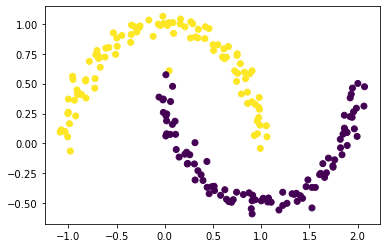

In [24]:
z_min[z_min >= 0] = 1
z_min[z_min < 0] = 0
plt.scatter(X[:,0], X[:,1], c = z_min)

Wow! Much better. We come close to correctly clustering the data right now.

# Part F

Did you find that the running time is little long when we run the optimizing function? The reason is that the way we use id explicitly optimization which is too slow to be practical. 

Now, we can use eigenvalues and eigenvectors of matrices to solve the problem.

The Rayleigh-Ritz Theorem states that the minimizing $\mathbf{z}$ must be the solution with smallest eigenvalue of the generalized eigenvalue problem 

$$ (\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{D}\mathbf{z}\;, \quad \mathbf{z}^T\mathbf{D}\mathbb{1} = 0$$

which is equivalent to the standard eigenvalue problem 

$$ \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{z}\;, \quad \mathbf{z}^T\mathbb{1} = 0\;.$$

Here the vector 𝐳 should be the eigenvector with the second-smallest eigenvalue becuase 𝟙 is the eigenvector with smallest eigenvalue. Therefore, find the eigenvector `z_eigvec` corresponding to its second-smallest eigenvalue.

In [25]:
# Laplacian matrix
L = np.linalg.inv(D)@(D-A)  

# get eigenvalue and eigenvector
eigval, eigvec = np.linalg.eig(L)

# sort the indices of eigenvalues
e_i = eigval.argsort()  

# order eigenvalue and eigenvector
eigval, eigvec = eigval[e_i], eigvec[:,e_i]

# take the eigenvector corresponding to second-smallest eigenvalue
z_eigvec = eigvec[:,1] 

Now, take a look how `z_eigvec` does.

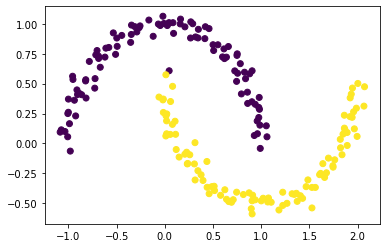

In [26]:
opt = np.ones_like(z_eigvec)
opt[z_eigvec < 0] = 0
plt.scatter(X[:,0], X[:,1], c = opt)

# Part G

Combine the previous works and write a function called `spectral_clustering(X, epsilon)`.

To constrct `spectral_clustering(X, epsilon)` function easier, let's write three function first:
1. `sim(X,epsilon)`    --- Construct the similarity matrix.
2. `Lap(A)`             --- Construct the Laplacian matrix.
3. `second_eigvec(L)`  --- Compute the eigenvector with second-smallest eigenvalue of the Laplacian matrix.

Then, we can use these three functions to write `spectral_clustering(X, epsilon)` function.

In [27]:
def similarity(X,epsilon):
    """
    Get and use the distance_matrix of X and parameter epsilon to contruct the similarity matrix.
    
    Input:
    X: the Euclidean coordinates of data points
    epsilon: the distance threshold to perform spectral clustering
    
    output:
    A: the similarity matrix
    """
    
    distance_matrix = pairwise_distances(X) 
    A = np.zeros_like(distance_matrix)
    A[distance_matrix <= epsilon] = 1
    np.fill_diagonal(A,0)
    
    return A


def Laplacian(A):
    """
    Construct the Laplacian matrix based on the the similarity matrix A.
    
    Input:
    A: the similarity matrix
    
    output:
    L: the Laplacian matrix
    """
    
    row_sum = A.sum(axis=1)
    D = np.zeros_like(A)
    np.fill_diagonal(D, row_sum)
    L = np.linalg.inv(D)@(D-A)
    
    return L


def second_eigvec(L):
    """
    Compute the eigenvector with second-smallest eigenvalue of the Laplacian matrix.
    
    Input:
    L: the Laplacian matrix
    
    output:
    z_eigvec: the eigenvector with second-smallest eigenvalue of the Laplacian matrix
    """
    
    eigval, eigvec = np.linalg.eig(L)
    e_i = eigval.argsort()  
    eigval, eigvec = eigval[e_i], eigvec[:,e_i]
    z_eigvec = eigvec[:,1] 
    
    return z_eigvec


def spectral_clustering(X, epsilon):
    """
    Generate an array containing the labels of the data points that negative labels
    are clustered into group zero and positive labels are clustered into group one.
    
    Input:
    X: the Euclidean coordinates of data points
    epsilon: the distance threshold to perform spectral clustering
    
    Output:
    opt: an array of binary labels indicating whether data point i is in group 0 or group 1
    """
    
    A = similarity(X, epsilon)
    L = Laplacian(A)
    z_eigvec = second_eigvec(L)
    opt = np.zeros_like(z_eigvec)
    opt[z_eigvec >= 0] = 1
    
    return opt

Demonstrate our function.

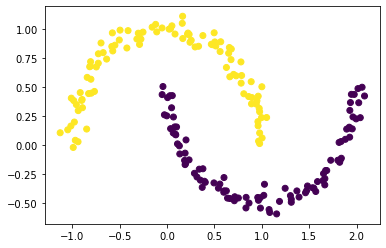

In [32]:
n = 200
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X, epsilon = 0.4))

# Part H

Generate a different data set and use `spectral_clustering(X, epsilon)` to cluster it.

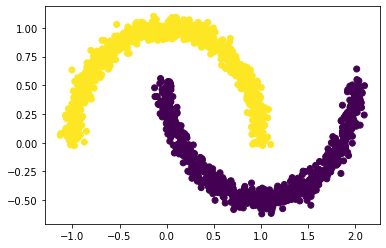

In [28]:
n = 1500   # add more samples
X, y = datasets.make_moons(n_samples=1500, shuffle=True, noise=0.05, random_state=None)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X, epsilon = 0.4))

Let's increase the `noise` and see what happen.

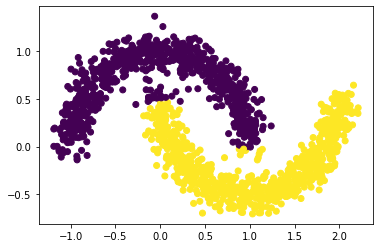

In [29]:
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,0.4))

Since increasing the noise will cause the plot become less condensed, We need to decrease our epsilon to fix it.

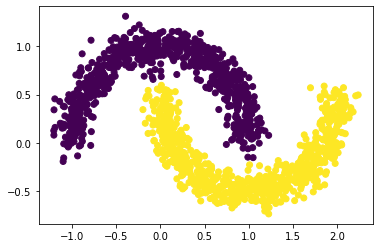

In [30]:
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,0.2))

Better now!

# Part I

Now try our `spectral_clustering(X, epsilon)` function on another "bull's eye" data set.

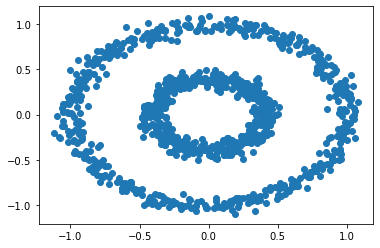

In [63]:
n = 1000
X, y = datasets.make_circles(n_samples=n, shuffle=True, noise=0.05, random_state=None, factor = 0.4)
plt.scatter(X[:,0], X[:,1])

Before trying our spectral clustering function, try K-means first. But, it is obviously not good for clustering this data set.

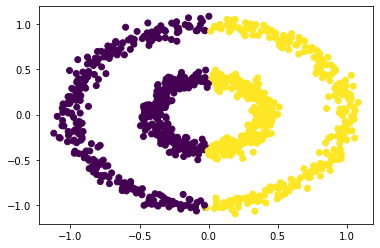

In [66]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Now it is our time! Try `epsilon` = 0.4 at first.

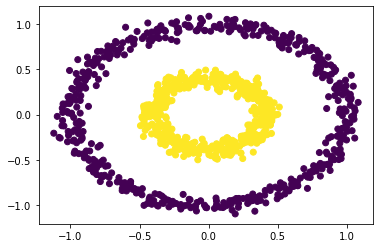

In [65]:
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,0.4))

Perfect! our function successfully separate the two circles. Besides, try other epsilons either and see what's going on.

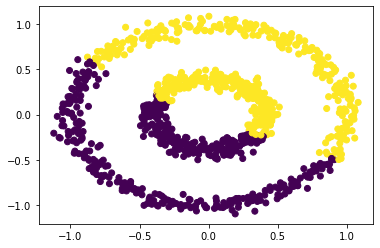

In [68]:
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,0.6))

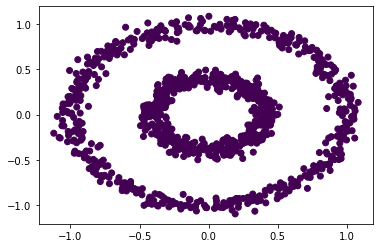

In [72]:
plt.scatter(X[:,0], X[:,1], c = spectral_clustering(X,0.3))

Whoops! When we set `epsilon =< 0.3` or `epsilon >= 0.6`, our function does not have a good performance or even no performance. Hence, we can conclude that **our epsilon should be between 0.3 and 0.6**.